# Steel Plate Defect Prediction

In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gc
import re as re
from collections import Counter
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier

import seaborn as sns
from tqdm.auto import tqdm
import math
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay
import warnings
warnings.filterwarnings('ignore')

import time
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier


%matplotlib inline
tqdm.pandas()

rc = {
    "axes.facecolor": "#FFF9ED",
    "figure.facecolor": "#FFF9ED",
    "axes.edgecolor": "#000000",
    "grid.color": "#EBEBE7",
    "font.family": "serif",
    "axes.labelcolor": "#000000",
    "xtick.color": "#000000",
    "ytick.color": "#000000",
    "grid.alpha": 0.4
}

sns.set(rc=rc)

from colorama import Style, Fore
red = Style.BRIGHT + Fore.RED
blu = Style.BRIGHT + Fore.BLUE
mgt = Style.BRIGHT + Fore.MAGENTA
gld = Style.BRIGHT + Fore.YELLOW
res = Style.RESET_ALL


# display all columns
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:,.2f}'.format

In [87]:
train = pd.read_csv('data/train.csv', index_col=0)
test = pd.read_csv('data/test.csv', index_col=0)
submission = pd.read_csv('data/sample_submission.csv',index_col=0)

In [88]:
def summary(df):
    print(f'data shape: {df.shape}')
    summ = pd.DataFrame(df.dtypes, columns=['data type'])
    summ['#missing'] = df.isnull().sum().values
    summ['%missing'] = df.isnull().sum().values / len(df) * 100
    summ['#unique'] = df.nunique().values
    desc = pd.DataFrame(df.describe(include='all').transpose())
    summ['min'] = desc['min'].values
    summ['max'] = desc['max'].values
    summ['average'] = desc['mean'].values
    summ['standard_deviation'] = desc['std'].values
    summ['first value'] = df.loc[0].values
    summ['second value'] = df.loc[1].values
    summ['third value'] = df.loc[2].values

    return summ

In [90]:
summary(train).style.background_gradient(cmap='YlOrBr')

data shape: (19219, 34)


,data type,#missing,%missing,#unique,min,max,average,standard_deviation,first value,second value,third value
X_Minimum,int64,0,0.000000,1191,0.000000,1705.000000,709.854675,531.544189,584.000000,808.000000,39.000000
X_Maximum,int64,0,0.000000,1259,4.000000,1713.000000,753.857641,499.836603,590.000000,816.000000,192.000000
Y_Minimum,int64,0,0.000000,3345,6712.000000,12987661.000000,1849756.040012,1903553.850679,909972.000000,728350.000000,2212076.000000
Y_Maximum,int64,0,0.000000,3341,6724.000000,12987692.000000,1846605.345439,1896295.137914,909977.000000,728372.000000,2212144.000000
Pixels_Areas,int64,0,0.000000,1154,6.000000,152655.000000,1683.987616,3730.319865,16.000000,433.000000,11388.000000
X_Perimeter,int64,0,0.000000,460,2.000000,7553.000000,95.654665,177.821382,8.000000,20.000000,705.000000
Y_Perimeter,int64,0,0.000000,331,1.000000,903.000000,64.124096,101.054178,5.000000,54.000000,420.000000
Sum_of_Luminosity,int64,0,0.000000,2595,250.000000,11591414.000000,191846.678235,442024.694057,2274.000000,44478.000000,1311391.000000
Minimum_of_Luminosity,int64,0,0.000000,162,0.000000,196.000000,84.808419,28.800344,113.000000,70.000000,29.000000
Maximum_of_Luminosity,int64,0,0.000000,98,39.000000,253.000000,128.647380,14.196976,140.000000,111.000000,141.000000


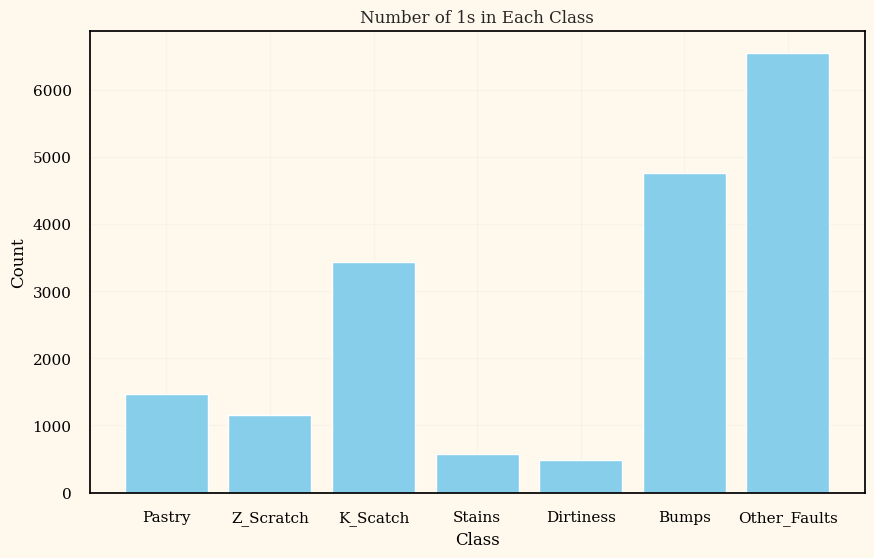

In [91]:
#let's check the label variables.

# Define the labels
labels = ['Pastry', 'Z_Scratch', 'K_Scatch', 'Stains', 'Dirtiness', 'Bumps', 'Other_Faults']

# Count the number of 1s in each class
counts = [train[label].sum() for label in labels]

# Create the bar plot
plt.figure(figsize=(10,6))
plt.bar(labels, counts, color='skyblue')
plt.title('Number of 1s in Each Class')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

In [97]:
# Column names in the DataFrame
columns = list(train.columns)

# Remove 'EC1' to 'EC6' and 'id'
features = [col for col in columns if col not in ['Pastry', 'Z_Scratch', 'K_Scatch', 'Stains', 'Dirtiness', 'Bumps', 'Other_Faults']]

features

['X_Minimum',
 'X_Maximum',
 'Y_Minimum',
 'Y_Maximum',
 'Pixels_Areas',
 'X_Perimeter',
 'Y_Perimeter',
 'Sum_of_Luminosity',
 'Minimum_of_Luminosity',
 'Maximum_of_Luminosity',
 'Length_of_Conveyer',
 'TypeOfSteel_A300',
 'TypeOfSteel_A400',
 'Steel_Plate_Thickness',
 'Edges_Index',
 'Empty_Index',
 'Square_Index',
 'Outside_X_Index',
 'Edges_X_Index',
 'Edges_Y_Index',
 'Outside_Global_Index',
 'LogOfAreas',
 'Log_X_Index',
 'Log_Y_Index',
 'Orientation_Index',
 'Luminosity_Index',
 'SigmoidOfAreas']